In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-future-sales-translated-dataset/shops_en.csv
/kaggle/input/predict-future-sales-translated-dataset/items_en.csv
/kaggle/input/predict-future-sales-translated-dataset/item_categories_en.csv
/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


In [2]:
sales_train = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
test = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv').set_index('ID')
items = pd.read_csv('/kaggle/input/predict-future-sales-translated-dataset/items_en.csv')
item_categories= pd.read_csv('/kaggle/input/predict-future-sales-translated-dataset/item_categories_en.csv')
shops =pd.read_csv('/kaggle/input/predict-future-sales-translated-dataset/shops_en.csv')

In [3]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
test.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [5]:
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   shop_id  214200 non-null  int64
 1   item_id  214200 non-null  int64
dtypes: int64(2)
memory usage: 4.9 MB


In [7]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [8]:
#try to reduce cost of the numerical features
l = ['date_block_num','shop_id','item_id','item_price','item_cnt_day']

for feature in l:
    if sales_train[feature].dtype == 'int64':
        sales_train[feature] =sales_train[feature].astype('int32')
    else:
        sales_train[feature] =sales_train[feature].astype('float32')

sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int32  
 2   shop_id         int32  
 3   item_id         int32  
 4   item_price      float32
 5   item_cnt_day    float32
dtypes: float32(2), int32(3), object(1)
memory usage: 78.4+ MB


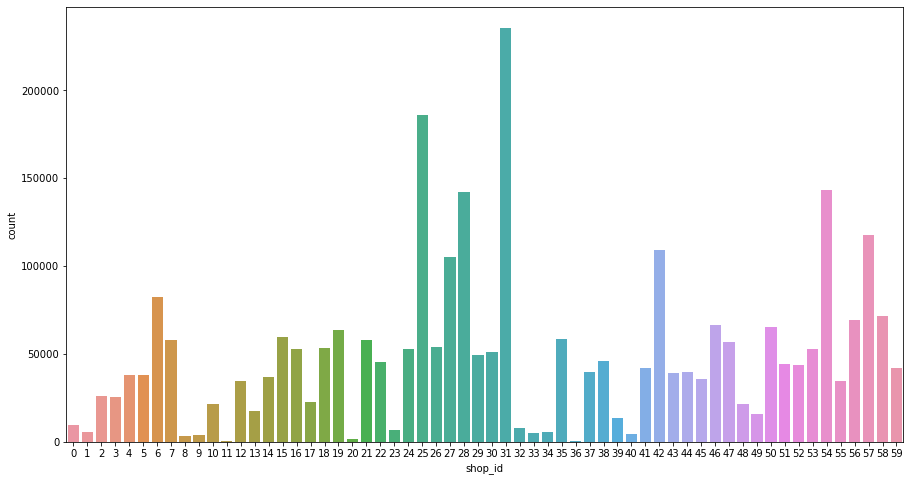

In [9]:
#we reduce 100 mb of ram usage without loosing information
plt.figure(figsize=(15,8))

sns.countplot(x= 'shop_id',data=sales_train)

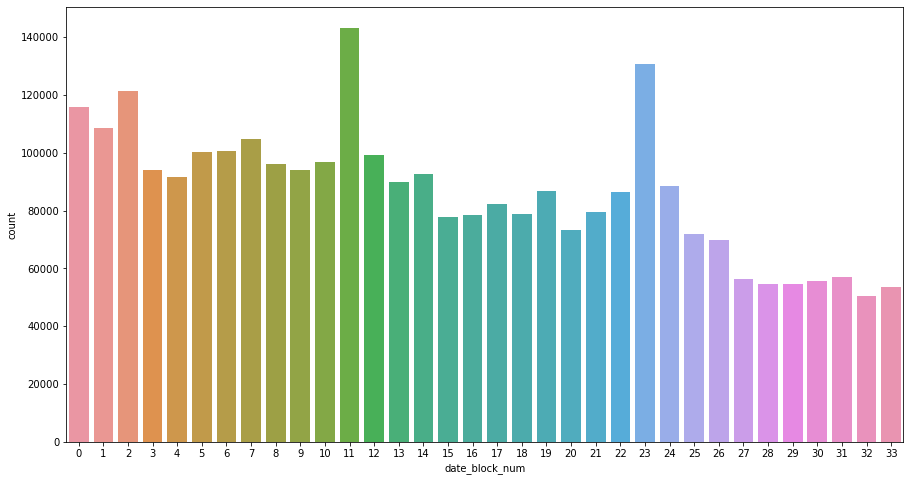

In [10]:
plt.figure(figsize=(15,8))
sns.countplot(x= 'date_block_num',data=sales_train)

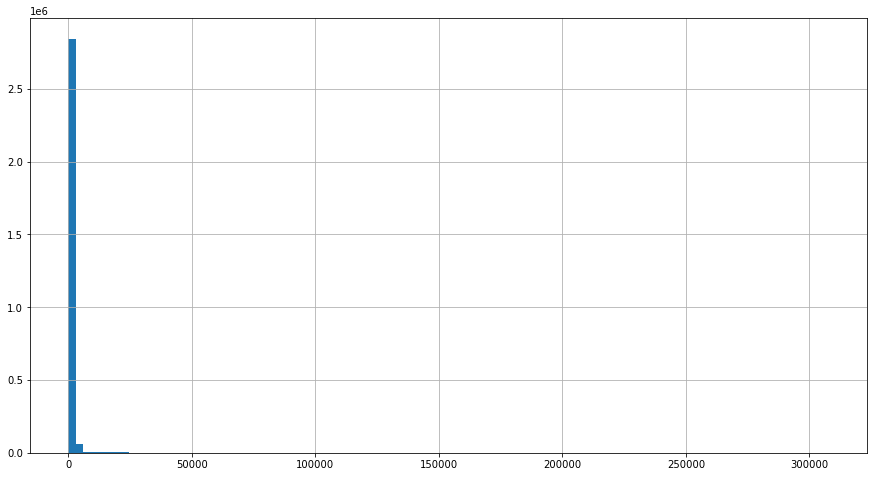

In [11]:
#at the end of the year there is an increases in the data set. (In december)
plt.figure(figsize=(15,8))
sales_train['item_price'].hist(bins=100)

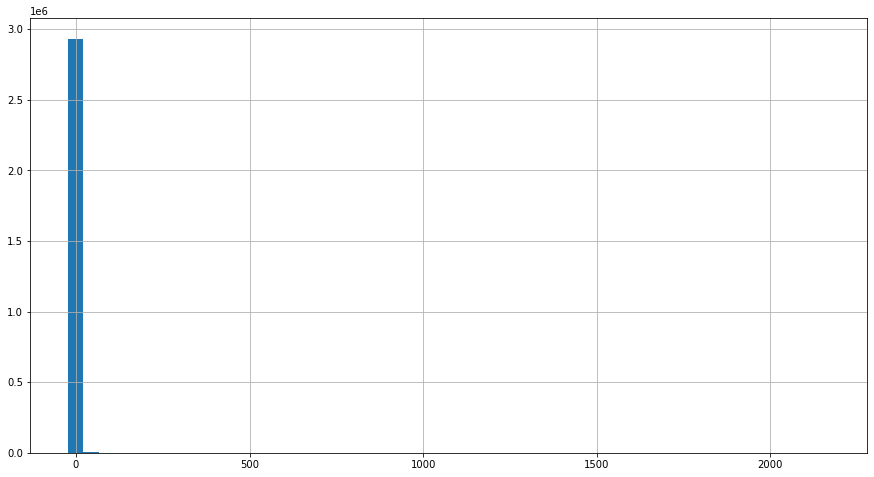

In [12]:
plt.figure(figsize=(15,8))
sales_train['item_cnt_day'].hist(bins=50)

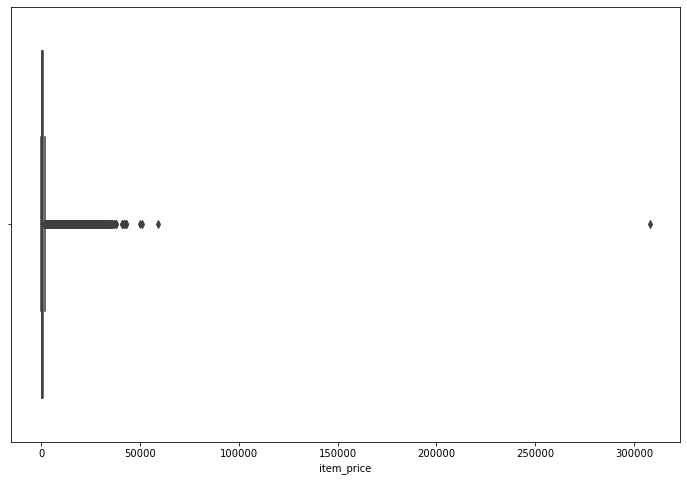

In [13]:
plt.figure(figsize=(12,8))
sns.boxplot(x=sales_train['item_price'])

In [14]:
#it is an interesting situation beacuse number of item sold is cannot be a negative number, maybe they returned item but it doesn't seem at all. Thus i drop them.
sales_train= sales_train.drop(sales_train[sales_train['item_cnt_day'] <0].index)
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.000000,1.0
1,03.01.2013,0,25,2552,899.000000,1.0
3,06.01.2013,0,25,2554,1709.050049,1.0
4,15.01.2013,0,25,2555,1099.000000,1.0
5,10.01.2013,0,25,2564,349.000000,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.000000,1.0
2935845,09.10.2015,33,25,7460,299.000000,1.0
2935846,14.10.2015,33,25,7459,349.000000,1.0
2935847,22.10.2015,33,25,7440,299.000000,1.0


In [15]:
sales_train = sales_train[sales_train['item_cnt_day'] <1000]
sales_train = sales_train[sales_train['item_price'] <100000]

In [16]:
sales_train


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.000000,1.0
1,03.01.2013,0,25,2552,899.000000,1.0
3,06.01.2013,0,25,2554,1709.050049,1.0
4,15.01.2013,0,25,2555,1099.000000,1.0
5,10.01.2013,0,25,2564,349.000000,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.000000,1.0
2935845,09.10.2015,33,25,7460,299.000000,1.0
2935846,14.10.2015,33,25,7459,349.000000,1.0
2935847,22.10.2015,33,25,7440,299.000000,1.0


In [17]:
#checking other tables
item_categories[:40]

,item_category_name,item_category_id
0,PC - Headsets / Headphones,0
1,Accessories - PS2,1
2,Accessories - PS3,2
3,Accessories - PS4,3
4,Accessories - PSP,4
5,Accessories - PSVita,5
6,Accessories - XBOX 360,6
7,Accessories - XBOX ONE,7
8,Tickets (digits),8
9,Delivery of goods,9


In [18]:
len(item_categories)

84

In [19]:

#it seems that there is a grouping categories between them thus i want to create a feature according to them
upper_category = list(item_categories['item_category_name'])
for i in range(len(item_categories)):
    if 'accessorie' in item_categories['item_category_name'][i].lower():
        upper_category[i] ='accessories'
    elif 'game' in item_categories['item_category_name'][i].lower():
        upper_category[i] ='games'
    elif 'card' in item_categories['item_category_name'][i].lower():
        upper_category[i] ='card'
    elif 'console' in item_categories['item_category_name'][i].lower():
        upper_category[i] ='consoles'
    elif 'movie' in item_categories['item_category_name'][i].lower():
        upper_category[i] ='movies'
    elif 'book' in item_categories['item_category_name'][i].lower():
        upper_category[i] ='books'
    elif 'music' in item_categories['item_category_name'][i].lower():
        upper_category[i] ='music'
    elif 'gift' in item_categories['item_category_name'][i].lower():
        upper_category[i] ='gifts'
    elif 'program' in item_categories['item_category_name'][i].lower():
        upper_category[i] ='program'
    else:
        upper_category[i] = 'else'

item_categories['upper_category']=upper_category
item_categories.loc[24,'upper_category'] ='games'
item_categories.loc[25,'upper_category'] ='games'
item_categories.loc[32,'upper_category'] ='card'
item_categories.loc[50,'upper_category'] ='books'
item_categories.loc[64,'upper_category'] ='gifts'
item_categories.loc[65,'upper_category'] ='gifts'
item_categories.loc[66,'upper_category'] ='gifts'
item_categories.loc[10:17,'upper_category']='consoles'

In [20]:
item_categories.head()

,item_category_name,item_category_id,upper_category
0,PC - Headsets / Headphones,0,else
1,Accessories - PS2,1,accessories
2,Accessories - PS3,2,accessories
3,Accessories - PS4,3,accessories
4,Accessories - PSP,4,accessories


In [21]:
encoder =sklearn.preprocessing.LabelEncoder()


In [22]:
items

,item_name,item_id,item_category_id
0,! POWER IN glamor (PLAST.) D,0,40
1,! ABBYY FineReader 12 Professional Edition Ful...,1,76
2,*** In the glory (UNV) D,2,40
3,*** BLUE WAVE (Univ) D,3,40
4,*** BOX (GLASS) D,4,40
...,...,...,...
22165,"Nuclear titbit 2 [PC, Digital Version]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
items['item_name'] = items['item_name'].str.replace('[^\w\s]','')
items

,item_name,item_id,item_category_id
0,POWER IN glamor PLAST D,0,40
1,ABBYY FineReader 12 Professional Edition Full...,1,76
2,In the glory UNV D,2,40
3,BLUE WAVE Univ D,3,40
4,BOX GLASS D,4,40
...,...,...,...
22165,Nuclear titbit 2 PC Digital Version,22165,31
22166,Язык запросов 1СПредприятия Цифровая версия,22166,54
22167,Язык запросов 1СПредприятия 8 CD Хрусталева ЕЮ,22167,49
22168,Яйцо для Little Inu,22168,62


In [24]:
vect = TfidfVectorizer(stop_words='english')
x = vect.fit_transform(items['item_name'])
k = items['item_category_id'].nunique()
model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
model.fit(x)

KMeans(max_iter=100, n_clusters=84, n_init=1)

In [25]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vect.get_feature_names()
for i in range(k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Top terms per cluster:
Cluster 0:
 2lp
 box
 powerball
 hz
 pb
 linux
 format
 250
 magazine
 2013
Cluster 1:
 bd
 trilogy
 air
 people
 collection
 days
 forsazh
 life
 12
 planet
Cluster 2:
 digital
 version
 pc
 edition
 war
 buh1s
 softklab
 set
 supplement
 2015
Cluster 3:
 kinect
 xbox
 360
 ms
 только
 для
 dance
 sports
 just
 russian
Cluster 4:
 speed
 need
 версия
 русская
 rivals
 wanted
 shift
 pc
 run
 limited
Cluster 5:
 union
 sat
 soviet
 56
 serve
 55
 53
 54
 52
 51
Cluster 6:
 цифровая
 версия
 pc
 набор
 borderlands
 1саудиокниги
 коллекция
 1спознавательная
 на
 1сшкола
Cluster 7:
 russian
 ps3
 documentation
 version
 ps
 essentials
 subtitles
 psp
 support
 vita
Cluster 8:
 3d
 bd
 bdbd
 2d
 shrek
 disc
 coral
 hobbit
 reef
 island
Cluster 9:
 collection
 wd
 new
 issue
 wot
 yoyo
 для
 mug
 blue
 коллекция
Cluster 10:
 grand
 collection
 theft
 auto
 pc
 jewel
 mp3cd
 iv
 cash
 shark
Cluster 11:
 фирм
 beatles
 remastered
 2cd
 floyd
 pink
 deluxe
 edition
 orig

In [26]:
order_centroids.shape

(84, 17531)

In [27]:
items = items.merge(item_categories,how ='inner',on='item_category_id')

items

,item_name,item_id,item_category_id,item_category_name,upper_category
0,POWER IN glamor PLAST D,0,40,Movie - DVD,movies
1,In the glory UNV D,2,40,Movie - DVD,movies
2,BLUE WAVE Univ D,3,40,Movie - DVD,movies
3,BOX GLASS D,4,40,Movie - DVD,movies
4,NEW American Graffiti UNI D,5,40,Movie - DVD,movies
...,...,...,...,...,...
22165,Battery GP 15AU LR6 Blister 2 pcs Ultra,22095,83,batteries,else
22166,Battery GP 24A LR03 Blister 2 pcs,22096,83,batteries,else
22167,Battery GP 24AU LR03 Blister 2 pcs Ultra,22097,83,batteries,else
22168,Элемент питания КОСМОС LR03 2BL,22098,83,batteries,else


In [28]:


items['upper_category'] = encoder.fit_transform(items['upper_category'])


In [29]:
items = items.drop(columns=['item_name','item_category_name','item_category_id'])
items

,item_id,upper_category
0,0,7
1,2,7
2,3,7
3,4,7
4,5,7
...,...,...
22165,22095,4
22166,22096,4
22167,22097,4
22168,22098,4


In [30]:
shops

,shop_name,shop_id
0,"! Yakutsk Ordzhonikidze, 56 Franc",0
1,"! Yakutsk TC ""Central"" Franc",1
2,"Adygea TC ""Mega""",2
3,"Balashikha TRC ""October-Kinomir""",3
4,"Volzhsky mall ""Volga Mall""",4
5,"Vologda SEC ""Marmalade""",5
6,"Voronezh (Plekhanovskaya, 13)",6
7,"Voronezh TRC ""Maksimir""",7
8,"Voronezh TRC City-Park ""City""",8
9,Itinerant trade,9


In [31]:
import string
shops['city'] = shops['shop_name'].str.replace('[^\w\s]','')
city = shops['city'].str.split(' ')
city
#every shop name start with city names thus we can create a dummy variable too

0                 [, Yakutsk, Ordzhonikidze, 56, Franc]
1                       [, Yakutsk, TC, Central, Franc]
2                                    [Adygea, TC, Mega]
3                     [Balashikha, TRC, OctoberKinomir]
4                         [Volzhsky, mall, Volga, Mall]
5                             [Vologda, SEC, Marmalade]
6                        [Voronezh, Plekhanovskaya, 13]
7                             [Voronezh, TRC, Maksimir]
8                       [Voronezh, TRC, CityPark, City]
9                                    [Itinerant, trade]
10                    [Zhukovsky, Street, Chkalov, 39m]
11                   [Zhukovsky, Street, Chkalov, 39m²]
12                          [Shop, Online, Emergencies]
13                   [Kazan, shopping, center, Bahetle]
14       [Kazan, shopping, mall, of, Parkhouse, II, of]
15                          [Kaluga, SEC, XXI, Century]
16                                   [Kolomna, TC, Rio]
17                    [Krasnoyarsk, TC, Vzletka,

In [32]:
city_names = []
for i in city:
    if len(i[0]) <3:
        city_names.append(i[1])
    else:
        city_names.append(i[0])


In [33]:
city_names =encoder.fit_transform(city_names)
city_names =pd.Series(city_names,name='encoded_cities')

In [34]:
shops =pd.concat([shops,city_names],axis=1)
shops

,shop_name,shop_id,city,encoded_cities
0,"! Yakutsk Ordzhonikidze, 56 Franc",0,Yakutsk Ordzhonikidze 56 Franc,28
1,"! Yakutsk TC ""Central"" Franc",1,Yakutsk TC Central Franc,28
2,"Adygea TC ""Mega""",2,Adygea TC Mega,0
3,"Balashikha TRC ""October-Kinomir""",3,Balashikha TRC OctoberKinomir,1
4,"Volzhsky mall ""Volga Mall""",4,Volzhsky mall Volga Mall,26
5,"Vologda SEC ""Marmalade""",5,Vologda SEC Marmalade,25
6,"Voronezh (Plekhanovskaya, 13)",6,Voronezh Plekhanovskaya 13,27
7,"Voronezh TRC ""Maksimir""",7,Voronezh TRC Maksimir,27
8,"Voronezh TRC City-Park ""City""",8,Voronezh TRC CityPark City,27
9,Itinerant trade,9,Itinerant trade,4


In [35]:
shops =shops.drop(columns=['shop_name','city'])
shops

,shop_id,encoded_cities
0,0,28
1,1,28
2,2,0
3,3,1
4,4,26
5,5,25
6,6,27
7,7,27
8,8,27
9,9,4


In [36]:
train_unique = sales_train['shop_id'].unique()
test_unique = test['shop_id'].unique()
diff = set(train_unique)- set(test_unique)
diff

{0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54}

In [37]:
items

,item_id,upper_category
0,0,7
1,2,7
2,3,7
3,4,7
4,5,7
...,...,...
22165,22095,4
22166,22096,4
22167,22097,4
22168,22098,4


In [38]:
for i in diff:
    sales_train = sales_train.drop(sales_train[sales_train['shop_id']==i].index)
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.000000,1.0
1,03.01.2013,0,25,2552,899.000000,1.0
3,06.01.2013,0,25,2554,1709.050049,1.0
4,15.01.2013,0,25,2555,1099.000000,1.0
5,10.01.2013,0,25,2564,349.000000,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.000000,1.0
2935845,09.10.2015,33,25,7460,299.000000,1.0
2935846,14.10.2015,33,25,7459,349.000000,1.0
2935847,22.10.2015,33,25,7440,299.000000,1.0


In [39]:
sales_train.loc[sales_train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
sales_train.loc[sales_train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
sales_train.loc[sales_train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [40]:
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.000000,1.0
1,03.01.2013,0,25,2552,899.000000,1.0
3,06.01.2013,0,25,2554,1709.050049,1.0
4,15.01.2013,0,25,2555,1099.000000,1.0
5,10.01.2013,0,25,2564,349.000000,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.000000,1.0
2935845,09.10.2015,33,25,7460,299.000000,1.0
2935846,14.10.2015,33,25,7459,349.000000,1.0
2935847,22.10.2015,33,25,7440,299.000000,1.0


In [41]:
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.000000,1.0
1,03.01.2013,0,25,2552,899.000000,1.0
3,06.01.2013,0,25,2554,1709.050049,1.0
4,15.01.2013,0,25,2555,1099.000000,1.0
5,10.01.2013,0,25,2564,349.000000,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.000000,1.0
2935845,09.10.2015,33,25,7460,299.000000,1.0
2935846,14.10.2015,33,25,7459,349.000000,1.0
2935847,22.10.2015,33,25,7440,299.000000,1.0


In [42]:
pivot = sales_train.pivot_table(index=['shop_id','item_id'], columns='date_block_num', values='item_cnt_day',aggfunc='sum').fillna(0.0)
pivot = pivot.reset_index()
pivot

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,2,27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,30,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,31,0.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2,33,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337054,59,22154,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
337055,59,22155,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
337056,59,22162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,4.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
337057,59,22164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0


In [43]:
test = test.merge(pivot,how= 'left',on=['shop_id','item_id'] ).fillna(0)
test 

,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,45,18454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
214196,45,16188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214197,45,15757,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214198,45,19648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
pivot = pivot.merge(shops,how= 'inner',on = 'shop_id')
pivot =pivot.merge(items,how='inner',on='item_id')
pivot

,shop_id,item_id,0,1,2,3,4,5,6,7,...,26,27,28,29,30,31,32,33,encoded_cities,upper_category
0,2,27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,5
1,3,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5
2,4,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26,5
3,5,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25,5
4,6,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337054,59,16270,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29,9
337055,59,17732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29,5
337056,59,18018,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29,8
337057,59,19992,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29,5


In [45]:
test = test.merge(items,how='inner',on='item_id')
test = test.merge(shops,how='inner',on='shop_id')
test

,shop_id,item_id,0,1,2,3,4,5,6,7,...,26,27,28,29,30,31,32,33,upper_category,encoded_cities
0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,5,25
1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,25
2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0,5,25
3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5,25
4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,45,18454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8,18
214196,45,16188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,18
214197,45,15757,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,18
214198,45,19648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,18


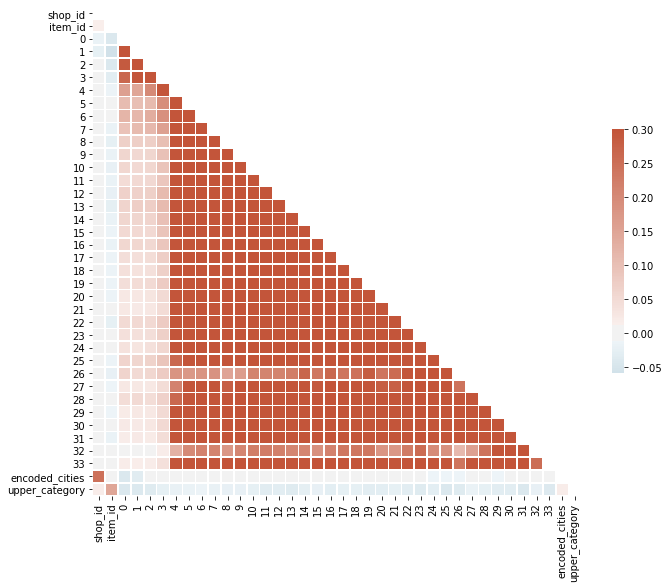

In [46]:
corr =pivot.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [47]:
param = {'max_depth':15, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.50, 
         'num_round':2000, 
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'}
xgbtrain = xgb.DMatrix(pivot.iloc[:,  (pivot.columns != 33)].values,pivot.iloc[:,pivot.columns == 33].values)
watchlist  = [(xgbtrain,'train-rmse')]

bst = xgb.train(param, xgbtrain)
preds = bst.predict(xgb.DMatrix(pivot.iloc[:,  (pivot.columns != 33)].values))
from sklearn.metrics import mean_squared_error 
rmse = np.sqrt(mean_squared_error(preds,pivot.iloc[:, pivot.columns == 33].values))
print(rmse)

[12:46:18] WARNING: ../src/learner.cc:516: 
Parameters: { num_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.47782236


In [48]:
preds = bst.predict(xgb.DMatrix(test.iloc[:,  (test.columns != 33)].values))

rmse = np.sqrt(mean_squared_error(preds,test.iloc[:, test.columns == 33].values))
print(rmse)



1.1520382


In [49]:
preds = list(map(lambda x: min(20,max(x,0)), list(preds)))

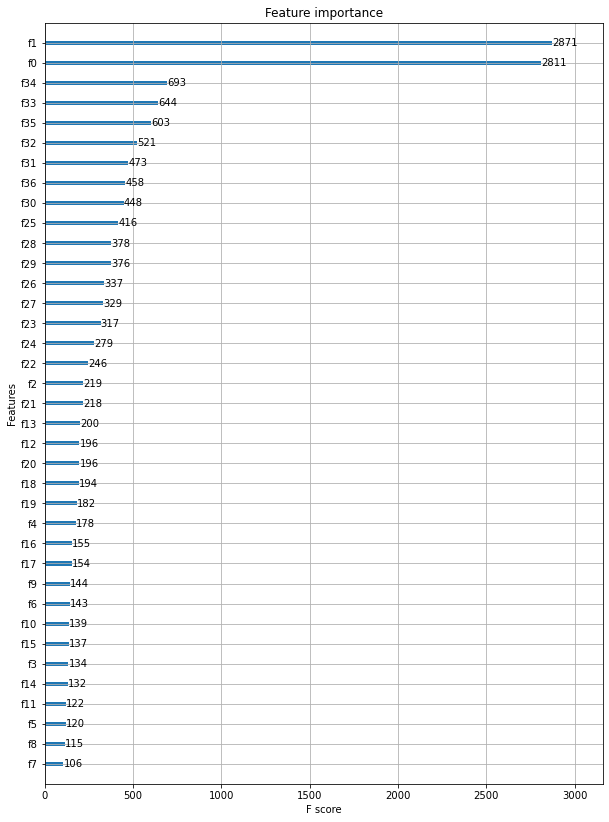

In [50]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(bst, (10,14))


In [51]:
sub = pd.DataFrame({'ID':test.index,'item_cnt_month':preds})

In [52]:
sub.to_csv('sub.csv',index=False)